In [348]:
import os
import torch
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2
from PIL import Image, ImageDraw, ImageFont

from yolo.visualize import render_bounding_boxes, plot
from torchvision.models import get_model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

from torchvision.ops import Conv2dNormActivation
from functools import partial

from yolo.model import YoloFPN
import itertools


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [413]:
dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017"
val_dataset = CocoDetection(
    root = os.path.join(dataset_root, "validation", "data"),
    annFile = os.path.join(dataset_root, "validation", "labels.json"),
)
val_dataset_v2 = wrap_dataset_for_transforms_v2(val_dataset)
# train_dataset = CocoDetection(
#     root = os.path.join(dataset_root, "train", "data"),
#     annFile = os.path.join(dataset_root, "train", "labels.json"),
# )

val_dataloader = torch.utils.data.DataLoader(
    val_dataset_v2,
    batch_size = 10,
    shuffle = False,
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [4]:
cat_id2name = {id: d["name"] for id,d in val_dataset.coco.cats.items()}

In [5]:
sample = val_dataset[0]

In [63]:
samplev2 = val_dataset_v2[0]

In [64]:
samplev2

(<PIL.Image.Image image mode=RGB size=640x426>,
 {'image_id': 139,
  'boxes': BoundingBoxes([[236.9800, 142.5100, 261.6800, 212.0100],
                 [  7.0300, 167.7600, 156.3500, 262.6300],
                 [557.2100, 209.1900, 638.5600, 287.9200],
                 [358.9800, 218.0500, 414.9800, 320.8800],
                 [290.6900, 218.0000, 352.5200, 316.4800],
                 [413.2000, 223.0100, 443.3700, 304.3700],
                 [317.4000, 219.2400, 338.9800, 230.8300],
                 [412.8000, 157.6100, 465.8500, 295.6200],
                 [384.4300, 172.2100, 399.5500, 207.9500],
                 [512.2200, 205.7500, 526.9600, 221.7200],
                 [493.1000, 174.3400, 513.3900, 282.6500],
                 [604.7700, 305.8900, 619.1100, 351.6000],
                 [613.2400, 308.2400, 626.1200, 354.6800],
                 [447.7700, 121.1200, 461.7400, 143.0000],
                 [549.0600, 309.4300, 585.7400, 399.1000],
                 [350.7600, 208.8400, 3

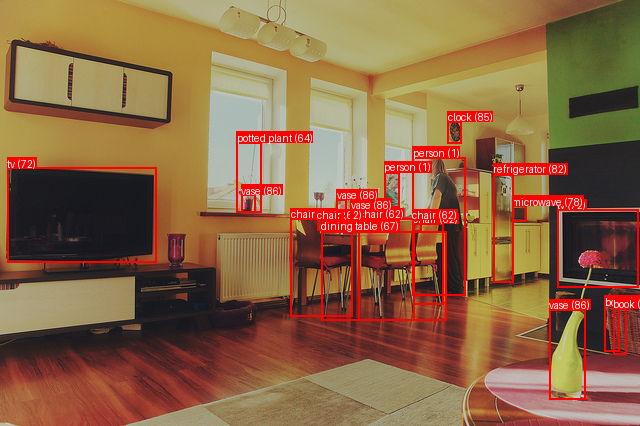

In [6]:
render_bounding_boxes(sample[0], sample[1], cat_id2name)

In [7]:
# backbone = resnet_fpn_backbone(
#     backbone_name='resnext50_32x4d',
#     weights=ResNeXt50_32X4D_Weights.DEFAULT,
#     trainable_layers=5,
#     norm_layer = torch.nn.BatchNorm2d,
#     extra_blocks = LastLevelP6P7(256, 256)
# )

In [272]:
backbone = get_model("resnext50_32x4d", weights=ResNeXt50_32X4D_Weights.DEFAULT, norm_layer = torch.nn.BatchNorm2d)
returned_layers = [2,3,4] # final 3 layers
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)} 
in_channels_stage2 = backbone.inplanes // 8
in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
body = IntermediateLayerGetter(backbone, return_layers = return_layers)
fpn = YoloFPN(in_channels_list, [256, 512, 1024])


In [273]:
x = torch.rand(1,3,608,608)
# x = torch.rand(1,3,416,416)
x = torch.rand(1,3,416,608)
output_body = body(x)
output_fpn = fpn(output_body)

In [274]:
print([(k, v.shape) for k, v in output_fpn.items()])

[('0', torch.Size([1, 256, 52, 76])), ('1', torch.Size([1, 512, 26, 38])), ('2', torch.Size([1, 1024, 13, 19]))]


In [280]:
from torch import nn
from typing import List, Tuple

ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]

class YoloHead(nn.Module):
    def __init__(self, in_channels: int, num_anchors: int = 3, num_classes: int = 80):
        super().__init__()
        # tx, ty, tw, th, objectness, 80 classes
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        feat_dim = num_anchors * (5 + num_classes)
        self.fc = nn.Conv2d(in_channels, feat_dim, kernel_size=1, bias=False)
    def forward(self, x):
        preds_BCHW = self.fc(x)        
        preds_BHWC = preds_BCHW.permute(0, 2, 3, 1)  # .shape [10,13,19,255]
        preds_BHW_anchor_feat = preds_BHWC.reshape(preds_BHWC.shape[:-1] + (self.num_anchors, -1)) # .shape [10,13,19,3,85]
        tx_ty_tw_th, objectness, class_logits = torch.split(preds_BHW_anchor_feat, [4, 1, self.num_classes], dim = -1)
        return {
            "tx_ty_tw_th": tx_ty_tw_th, # .shape [10,13,19,3,4]
            "objectness": objectness,
            "class_logits": class_logits
        }

class DecodeBbox(nn.Module):
    def __init__(self, feature_width: int, feature_height: int, scale: int, anchors_list: List[Tuple[int,int]]):
  from torchvision.transforms.v2.functional import convert_bounding_box_format
      self.scale = scale
        x_axis = torch.arange(feature_width)
        y_axis = torch.arange(feature_height)
        grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij") # .shape [13,19]

        grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
        # reshape to [1,13,19,1,2] to broadcast against tx_ty of shape [N,13,19,n_anchors,2]
        self.grid_xy = grid_xy.view([1, *grid_xy.shape[:2], 1, 2])
        
        
        anchors = torch.asarray(anchors_list)  # w, h
        # reshape to [1,1,1,n_anchors,2] to broadcast against tw_th of shape [N,13,19,n_anchors,2]
        self.anchors = anchors.view([1, 1, 1, *anchors.shape])
    
    def forward(self, tx_ty_tw_th):
        tx_ty, tw_th = torch.split(tx_ty_tw_th, [2, 2], dim=-1) # shape [N,13,19,n_anchors,2]
        bx_by = self.scale * (torch.sigmoid(tx_ty) + self.grid_xy)
        bw_bh = torch.exp(tw_th) * self.anchors
        bx_by_bw_bh = torch.concatenate([bx_by, bw_bh], axis = -1) # [N,13,19,n_anchors,4]
        bx_by_bw_bh_flatten = bx_by_bw_bh.reshape([-1, 4]) # [N*13*19*n_anchors, 4]
        return bx_by_bw_bh_flatten
    

In [281]:
yolo_head = YoloHead(256)
output_yolo_head = yolo_head(output_fpn["0"])

In [283]:
print([(k, v.shape) for k, v in output_yolo_head.items()])

[('tx_ty_tw_th', torch.Size([1, 52, 76, 3, 4])), ('objectness', torch.Size([1, 52, 76, 3, 1])), ('class_logits', torch.Size([1, 52, 76, 3, 80]))]


## (Scratch) bounding box decode

In [183]:
per_anchor_dim = 5 + 80
feat_dim = 3 * per_anchor_dim
preds = torch.randn((10, feat_dim, 19, 19))

In [143]:
anchors = torch.asarray(ANCHORS[:3])  # w, h

In [147]:
scale_factor = 32
num_anchors = 3
anchor_idx = 0
x_index = 1
y_index = 1
# iterate through anchor index
single_anchor_encoded = preds[:,x_index,y_index][anchor_idx*per_anchor_dim:(anchor_idx+1)*per_anchor_dim]
cx_cy = scale_factor * torch.tensor([x_index, y_index])
bx_by = torch.sigmoid(single_anchor_encoded[:,0:2]) + cx_cy
bw_bh = torch.exp(single_anchor_encoded[:,2:4]) * anchors[anchor_idx]

In [148]:
# preds[...,torch.tensor([0,1,2])] == preds[...,slice(0,3)] 

In [274]:
preds_BCHW = torch.randn((10, feat_dim, 13, 19))
# preds.shape [10, 255, 13, 19]
preds_h, preds_w = preds_BCHW.shape[-2:]
n_batch = preds_BCHW.shape[0]

preds_BHWC = preds_BCHW.permute(0, 2, 3, 1)  # .shape [10,13,19,255]
preds_BHW_anchor_feat = preds_BHWC.reshape(preds_BHWC.shape[:-1] + (num_anchors, -1)) # .shape [10,13,19,3,85]
tx_ty_tw_th, objectness, class_logits = torch.split(preds_BHW_anchor_feat, [4, 1, 80], dim = -1)

In [251]:
x_axis = torch.arange(preds_w)
y_axis = torch.arange(preds_h)
grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij")
grid_y = grid_y * scale_factor # .shape [13, 19]
grid_x = grid_x * scale_factor

In [252]:
grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
grid_xy = grid_xy.view([1, *grid_xy.shape[:2], 1, 2]) # .shape [1, 13, 19, 1, 2]

In [254]:
bx_by = torch.sigmoid(tx_ty) + grid_xy # .shape [10,13,19,3,2]

In [256]:
anchors = torch.asarray(ANCHORS[:3])  # w, h
anchors = anchors.view([1, 1, 1, *anchors.shape])bx_by = torch.sigmoid(tx_ty) + grid_xy # .shape [10,13,19,3,2]
bw_bh = torch.exp(tw_th) * anchors  # .shape [10,13,19,3,2]

In [281]:
bx_by_bw_bh = torch.concatenate([bx_by, bw_bh], axis = -1) # [10,13,19,3,4]
bx_by_bw_bh_flatten = bx_by_bw_bh.reshape([-1, 4]) # [7410, 4]

In [282]:
bx_by_bw_bh_flatten.shape

torch.Size([7410, 4])

In [173]:
preds = torch.randn((10, feat_dim, 19, 19))
# preds.shape [10, 255, 19, 19]
box_encode_idx = torch.concatenate([per_anchor_dim * i + torch.arange(4) for i in range(num_anchors)])
box_encode = preds[:, box_encode_idx, :] # box_encode.shape [10, 12, 19, 19]
# box_encode_flatten = box_encode.view((box_encode.shape[0], -1, 4)) # .shape [10,1083,4]

# box_encode[:,:,:] = torch.arange(12) # to ensure that the view looks correct
box_encode_with_anchor_shape = box_encode.shape[:-1] + (num_anchors,-1)
box_encode_with_anchor = box_encode.view(box_encode_with_anchor_shape) # .shape [10, 19, 19, 3, 4]
# box_encode_flatten = box_encode_with_anchor.view((box_encode_with_anchor.shape[0], -1, 4)) # .shape [10, 4332]
bx_by = torch.sigmoid(box_encode_with_anchor[...,0:2]) + cx_cy

## (Scratch) bounding box encode

In [14]:
bbox_list = [sample[1][i]["bbox"] for i in range(len(sample[1]))]
bboxes = torch.tensor(bbox_list) # 20,4

In [21]:
# encode the boxes to tx_ty_tw_th
# Just need the scale factor and anchor that's associated with the ground truth bounding box 

bbox = torch.tensor([[236.9800, 142.5100,  24.7000,  69.5000]])
anchors = torch.tensor([30, 61]) # w, h

scale = 32
bbox_scaled = bbox[:,:2] / scale
# the cx_cy associated with the GT box
cx_cy = torch.floor(bbox_scaled)
qxy = bbox_scaled - cx_cy 
tx_ty = torch.log(qxy / (1 - qxy))
print("tx_ty: ", tx_ty)

tw_th = torch.log(bbox[:,2:4] / anchors)
print("tw_th: ", tw_th)

tx_ty:  tensor([[-0.3821, -0.1868]])
tw_th:  tensor([[-0.1944,  0.1305]])


## (Scratch) Finding the ground truth to anchor box assignments

In [172]:
from torchvision import tv_tensors
from torchvision.transforms import v2
from typing import Any, Dict
from torchvision.transforms.v2._utils import _get_fill
from torchvision.ops import box_iou, box_convert

In [10]:
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]

class PadToMultipleOf32(v2.Pad):
    def __init__(self, fill=0, padding_mode='constant'):
        super().__init__(padding=0, fill=fill, padding_mode=padding_mode)
    
    def transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        # bounding boxes don't need padding since padding is applied
        # to the bottom and right sides
        padding = 0
        if isinstance(inpt, tv_tensors.Image):
            height, width = inpt.shape[-2:]
            pad_width = (32 - width % 32) % 32
            pad_height = (32 - height % 32) % 32
            padding = (0, 0, pad_width, pad_height)
        fill = _get_fill(self._fill, type(inpt))
        return self._call_kernel(v2.functional.pad, inpt, padding=padding, fill=fill, padding_mode=self.padding_mode)

# For a batch that contains images of different sizes, we will have to find the minimum size, the closest multiple of 32, and then pad all the images to that size.

anchors:  [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
original image.size: torch.Size([3, 426, 640])


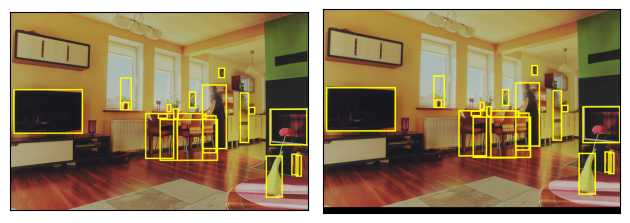

In [20]:
# anchor_to_gt_assignment [13,19,3] index into list of G ground truth boxes per image
# FPN output scales for an input image of size (416,608)
# [('0', torch.Size([1, 256, 52, 76])), ('1', torch.Size([1, 512, 26, 38])), ('2', torch.Size([1, 1024, 13, 19]))]
# bboxes = tv_tensors.BoundingBoxes(
#     [ann["bbox"] for ann in sample[1]],
#     format="XYWH",
#     canvas_size=image.shape[-2:],
# )
# category_ids = torch.tensor([x["category_id"] for x in sample[1]], dtype=torch.long)


print("anchors: ", ANCHORS)

pil_image, target = val_dataset_v2[0]
image = tv_tensors.Image(pil_image, dtype=torch.uint8) #CHW
transforms = v2.Compose([
    v2.Resize(size = None, max_size = 608), # bilinear
    PadToMultipleOf32(),
])
print(f"original image.size: {image.shape}")
image_trans, target_trans = transforms(image, target)
plot([(image, target["boxes"]), (image_trans, target_trans["boxes"])])

In [269]:
all_anchors = torch.tensor(ANCHORS)
scales = torch.tensor([8, 16, 32], dtype=torch.float)

num_anchors = 3
index = 1
anchors = all_anchors[num_anchors * index: num_anchors * (index + 1)]
scale = scales[index]
scaled_anchors = anchors / (2 * scale) # w/2, h/2

scaled_image_height = image_trans.shape[-2] / scale
scaled_image_width = image_trans.shape[-1] / scale

print(f"At scale: {scale}, image resized from: {image_trans.shape[-2:]} to {(scaled_image_height.item(), scaled_image_width.item())}")
print(f"At scale: {scale}, anchors resized from:\n{anchors}\nto\n{anchors / scale}")


x_axis = torch.arange(scaled_image_width)
y_axis = torch.arange(scaled_image_height)
grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij") # .shape [13,19]
grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
grid_xy_centers = grid_xy + 0.5 # center the anchor boxes in each unit grid cell


# Expand grid_centers and anchors to enable broadcasting
grid_centers_expanded = grid_xy_centers.unsqueeze(-2)  # Shape: (13, 19, 1, 2)
scaled_anchors_expanded = scaled_anchors.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 2)
# Compute grid_lefts in a vectorized manner to get 2x tensors of shape (13,19,3,2)
grid_anchors_xyxy = torch.cat([grid_centers_expanded - scaled_anchors_expanded, grid_centers_expanded + scaled_anchors_expanded], axis=-1)
grid_anchors_xyxy_flatten = grid_anchors_xyxy.flatten(end_dim=-2) # .shape (13*19*3, 2)
print(f"grid_anchors_xyxy.shape: {grid_anchors_xyxy.shape}")

scaled_boxes = target_trans["boxes"] / scale
ious = box_iou(scaled_boxes, grid_anchors_xyxy_flatten)
iou_top_values, iou_top_indices = ious.topk(5)
print("iou top_values:\n", iou_top_values)
print("iou top_indices:\n", iou_top_indices)

At scale: 16.0, image resized from: torch.Size([416, 608]) to (26.0, 38.0)
At scale: 16.0, anchors resized from:
tensor([[ 30,  61],
        [ 62,  45],
        [ 59, 119]])
to
tensor([[1.8750, 3.8125],
        [3.8750, 2.8125],
        [3.6875, 7.4375]])
grid_anchors_xyxy.shape: torch.Size([26, 38, 3, 4])
iou top_values:
 tensor([[0.6531, 0.4452, 0.4423, 0.3923, 0.3219],
        [0.3667, 0.3667, 0.3667, 0.3667, 0.3667],
        [0.5253, 0.5253, 0.5253, 0.4835, 0.4835],
        [0.6317, 0.6317, 0.6162, 0.6162, 0.5067],
        [0.6427, 0.6427, 0.5835, 0.5835, 0.5506],
        [0.7411, 0.6256, 0.5526, 0.3759, 0.3475],
        [0.1231, 0.1231, 0.1231, 0.0808, 0.0808],
        [0.7241, 0.6562, 0.6348, 0.6146, 0.5782],
        [0.2660, 0.2660, 0.2074, 0.1745, 0.1745],
        [0.1159, 0.1159, 0.1159, 0.0942, 0.0942],
        [0.4226, 0.4226, 0.4226, 0.3266, 0.3148],
        [0.3227, 0.2577, 0.2536, 0.2117, 0.2117],
        [0.2945, 0.2512, 0.2232, 0.2144, 0.1919],
        [0.1505, 0.1505, 

In [257]:
gt_box_index = -2
grid_anchors_indices = iou_top_indices[gt_box_index][:3]

In [258]:
select_grid_anchors = scale * grid_anchors_xyxy_flatten[grid_anchors_indices]

In [246]:
select_grid_anchors_bboxes = tv_tensors.BoundingBoxes(
    select_grid_anchors,
    format="XYXY",
    canvas_size=image_trans.shape[-2:],
)
select_gt_bboxes = tv_tensors.BoundingBoxes(
    target_trans["boxes"][gt_box_index],
    format="XYXY",
    canvas_size=image_trans.shape[-2:],
)

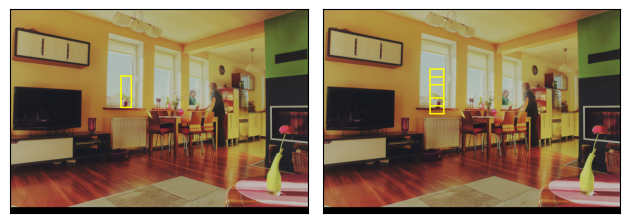

In [247]:
plot([(image_trans, select_gt_bboxes), (image_trans, select_grid_anchors_bboxes)])

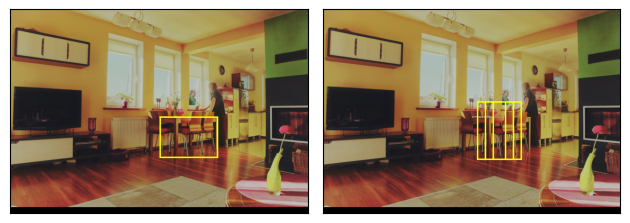

In [198]:
plot([(image_trans, select_gt_bboxes), (image_trans, select_grid_anchors_bboxes)])

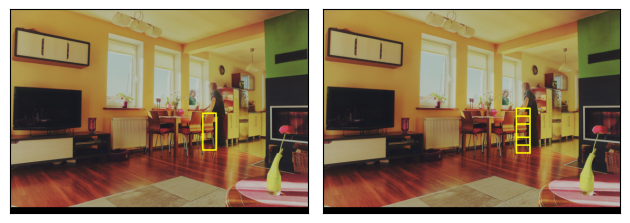

In [163]:
plot([(image_trans, select_gt_bboxes), (image_trans, select_grid_anchors_bboxes)])

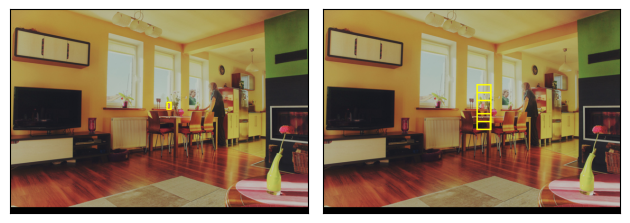

In [159]:
plot([(image_trans, select_gt_bboxes), (image_trans, select_grid_anchors_bboxes)])

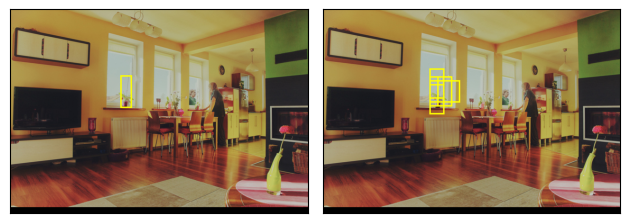

In [138]:
plot([(image_trans, select_gt_bboxes), (image_trans, select_grid_anchors_bboxes)])

In [259]:
target_trans["boxes"][gt_box_index] / scale

tensor([19.9969, 11.8248, 20.5746, 12.8164])

In [260]:
gt_box_center = box_convert(target_trans["boxes"][gt_box_index] / scale, "xyxy", "cxcywh")[:2].floor()
gt_box_center

tensor([20., 12.])

In [261]:
# hypothesize that the grid anchor cxcy coordinates (the top-left corner of the grid) must be at gt_box_center.floor()

In [262]:
debug_grid_xy = grid_xy.unsqueeze(-2) # (26,38,1,2)
debug_grid_xyxy_by_anchors = torch.cat(num_anchors * [debug_grid_xy], dim=-2) # .shape [26, 38, 3, 2]

In [263]:
print("grid_xyxy @ x=22, y=16: ", grid_xy[16,22])
print("each of the anchors @ x=22, y=16 have the correct values:\n", debug_grid_xyxy_by_anchors[16,22])
# grid_cxcy_by_anchors[

grid_xyxy @ x=22, y=16:  tensor([22., 16.])
each of the anchors @ x=22, y=16 have the correct values:
 tensor([[22., 16.],
        [22., 16.],
        [22., 16.]])


In [264]:
debug_grid_xyxy_flatten = debug_grid_xyxy_by_anchors.reshape(-1,2) # .shape [2964, 2]

In [265]:
debug_grid_xyxy_flatten[grid_anchors_indices] # should match up with (22,16), but it doesn't because the anchors aren't very good fits

tensor([[20., 11.],
        [20., 12.],
        [20., 13.]])

In [266]:
grid_anchors_indices

tensor([1314, 1428, 1542])

In [267]:
iou_top_values[gt_box_index]

tensor([0.0801, 0.0801, 0.0801, 0.0600, 0.0600])

In [268]:
# confirmation that the grid anchor cxcy coordinates are at gt_box_center

In [80]:
# Scratch

grid_centers = torch.randn(13,19,2)
anchors = torch.randn(3,2)
grid_lefts = [grid_centers - anchor for anchor in anchors]
grid_lefts = [x.unsqueeze(-2) for x in grid_lefts]
grid_left_by_anchor = torch.concatenate(grid_lefts, axis=-2) # 13, 19, 3, 2

In [37]:
# Expand grid_centers and anchors to enable broadcasting
grid_centers_expanded = grid_centers.unsqueeze(-2)  # Shape: (13, 19, 1, 2)
anchors_expanded = anchors.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 2)
# Compute grid_lefts in a vectorized manner
grid_left_by_anchor2 = grid_centers_expanded - anchors_expanded

In [39]:
torch.allclose(grid_left_by_anchor, grid_left_by_anchor2)

True

In [342]:
image_trans.shape

torch.Size([3, 416, 608])

In [359]:
416 / 32

13.0

In [361]:
torch.arange(13) * 32

tensor([  0,  32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384])

In [363]:
torch.arange(0, 416, 32)

tensor([  0,  32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384])

In [364]:
x_axis = torch.arange(0, 608, 32)
y_axis = torch.arange(0, 416, 32)
grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij")



In [412]:
################################
# Create a Lx4 anchor box grid
# where for an inupt image of size (416,608)
# and feature pyramids downsampling by factors x8, x16, x32 to (52,76), (26,38), (13,19)
# then L = 52*76*3 + 26*38*3 + 13*19*3
###############################


def make_spatial_anchors(anchors_list: List[Tuple[int,int]], scale: int, image_height: int, image_width: int, verbose=False):
    ## Need the anchor boxes to be in the original image resolution
    
    num_anchors = len(anchors_list)
    anchor_halfs = torch.tensor(anchors_list, dtype=torch.float) / 2 # w/2, h/2

    x_axis = torch.arange(0, image_width, scale)
    y_axis = torch.arange(0, image_height, scale)
    grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij") # .shape [13,19]
    grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
    grid_xy_centers = grid_xy + 0.5 * scale # center the anchor boxes in each grid cell

    # Expand grid_centers and anchors to enable broadcasting
    grid_centers_expanded = grid_xy_centers.unsqueeze(-2)  # Shape: (13, 19, 1, 2)
    anchor_halfs_expanded = anchor_halfs.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 2)
    # Compute the upper-left xy and lower-right xy coordinates in a vectorized manner
    # to get 2x tensors of shape (13,19,3,2), then concatenated to (13,19,3,4)
    grid_anchors_xyxy = torch.cat([grid_centers_expanded - anchor_halfs_expanded, grid_centers_expanded + anchor_halfs_expanded], axis=-1)
    grid_anchors_xyxy_flatten = grid_anchors_xyxy.flatten(end_dim=-2) # .shape (13*19*3, 4)
    
    if verbose:
        print(f"[make_spatial_anchors][scale: /{scale}] image resized from ({image_height}, {image_width}) to ({image_height / scale}, {image_width / scale})")
        s1,s2,s3 = grid_anchors_xyxy.shape[:3]
        print(f"[make_spatial_anchors][scale: /{scale}] L={s1}x{s2}x{s3}={s1*s2*s3} spatial_anchors is (L,4)={tuple(grid_anchors_xyxy_flatten.shape)}")
    return grid_anchors_xyxy_flatten


num_anchors = 3
anchors_per_scale = list(itertools.batched(ANCHORS, num_anchors))
scales = [8, 16, 32]
image_height, image_width = image_trans.shape[-2:]

spatial_anchors_per_scale = [make_spatial_anchors(anchors, scale, image_height, image_width, verbose = True) for anchors, scale in zip(anchors_per_scale, scales)]
spatial_anchors = torch.cat(spatial_anchors_per_scale, axis=0)

print("spatial_anchors.shape: ", spatial_anchors.shape)

[make_spatial_anchors][scale: /8] image resized from (416, 608) to (52.0, 76.0)
[make_spatial_anchors][scale: /8] L=52x76x3=11856 spatial_anchors is (L,4)=(11856, 4)
[make_spatial_anchors][scale: /16] image resized from (416, 608) to (26.0, 38.0)
[make_spatial_anchors][scale: /16] L=26x38x3=2964 spatial_anchors is (L,4)=(2964, 4)
[make_spatial_anchors][scale: /32] image resized from (416, 608) to (13.0, 19.0)
[make_spatial_anchors][scale: /32] L=13x19x3=741 spatial_anchors is (L,4)=(741, 4)
spatial_anchors.shape:  torch.Size([15561, 4])


In [401]:
ious = box_iou(target_trans["boxes"], spatial_anchors)
# Find the max value per row
max_ious, _ = torch.max(ious, dim=1, keepdim=True)
# Compare each element to the max value and get the indices of all elements that match the max value
tied_max_ious = (ious == max_ious).nonzero(as_tuple=False)

# Group indices by row
result = {}
for row, col in tied_max_ious:
    if row.item() not in result:
        result[row.item()] = []
    result[row.item()].append(col.item())



In [406]:
# >= 0 index into gt boxes (highest IOU) per image
# -1: ignore (IOU > 0.5)
# -2: negative examples. anchors with IOU <= 0.5
spatial_anchor_mask = -torch.ones_like(spatial_anchors, dtype=torch.int32)

In [411]:
spatial_anchor_mask.shape

torch.Size([15561, 4])

In [408]:
tied_max_ious

tensor([[    0, 13038],
        [    1, 15168],
        [    2, 15270],
        [    3, 13634],
        [    3, 13748],
        [    4, 13625],
        [    4, 13739],
        [    5, 13641],
        [    6,  6042],
        [    6,  6045],
        [    7, 13418],
        [    8,  5155],
        [    9,  5883],
        [   10, 13311],
        [   10, 13425],
        [   10, 13539],
        [   11,  8881],
        [   11,  9109],
        [   12,  8884],
        [   12,  9112],
        [   13,  3583],
        [   14, 14235],
        [   14, 14349],
        [   15,  6054],
        [   16,  6075],
        [   17,  5559],
        [   18,  5592],
        [   19, 15309]])

In [373]:
ious = box_iou(target_trans["boxes"], spatial_anchors)
iou_top_values, iou_top_indices = ious.topk(5)
print("iou top_values:\n", iou_top_values)
print("iou top_indices:\n", iou_top_indices)

iou top_values:
 tensor([[0.6531, 0.4452, 0.4423, 0.3923, 0.3219],
        [0.7553, 0.5833, 0.5400, 0.4482, 0.4132],
        [0.5527, 0.5253, 0.5253, 0.5253, 0.5027],
        [0.6317, 0.6317, 0.6162, 0.6162, 0.5067],
        [0.6427, 0.6427, 0.5835, 0.5835, 0.5506],
        [0.7411, 0.6256, 0.5526, 0.3759, 0.3475],
        [0.4241, 0.4241, 0.2969, 0.2969, 0.2911],
        [0.7241, 0.6562, 0.6348, 0.6146, 0.5782],
        [0.8040, 0.5617, 0.5429, 0.3609, 0.3609],
        [0.5957, 0.4145, 0.4145, 0.3455, 0.2794],
        [0.4226, 0.4226, 0.4226, 0.3266, 0.3148],
        [0.6062, 0.6062, 0.4564, 0.4441, 0.3227],
        [0.5632, 0.5632, 0.4894, 0.3743, 0.3030],
        [0.4137, 0.4118, 0.3601, 0.3601, 0.3560],
        [0.5976, 0.5976, 0.4302, 0.4294, 0.4221],
        [0.4814, 0.4812, 0.4667, 0.4516, 0.2810],
        [0.7056, 0.3041, 0.2263, 0.2263, 0.2128],
        [0.5178, 0.4705, 0.4705, 0.3684, 0.3191],
        [0.7398, 0.3287, 0.3055, 0.3055, 0.2556],
        [0.7473, 0.5794, 0.4972, 

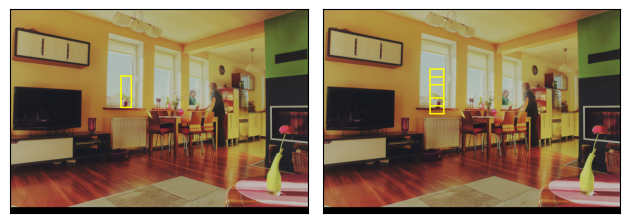

In [386]:
gt_box_index = 0
spatial_anchors_indices = iou_top_indices[gt_box_index][:3]

select_spatial_anchors = tv_tensors.BoundingBoxes(
    spatial_anchors[spatial_anchors_indices],
    format="XYXY",
    canvas_size=image_trans.shape[-2:],
)
select_gt_bboxes = tv_tensors.BoundingBoxes(
    target_trans["boxes"][gt_box_index],
    format="XYXY",
    canvas_size=image_trans.shape[-2:],
)
# import torchvision
# bbox0 = torchvision.tv_tensors.wrap(bbox[0], like=bbox)
plot([(image_trans, select_gt_bboxes), (image_trans, select_spatial_anchors)])

In [393]:
# Find the max value per row
max_ious, _ = torch.max(ious, dim=1, keepdim=True)
# Compare each element to the max value and get the indices of all elements that match the max value
tied_max_ious = (ious == max_ious).nonzero(as_tuple=False)

# Group indices by row
result = {}
for row, col in tied_max_ious:
    if row.item() not in result:
        result[row.item()] = []
    result[row.item()].append(col.item())

In [394]:
result

{0: [13038],
 1: [15168],
 2: [15270],
 3: [13634, 13748],
 4: [13625, 13739],
 5: [13641],
 6: [6042, 6045],
 7: [13418],
 8: [5155],
 9: [5883],
 10: [13311, 13425, 13539],
 11: [8881, 9109],
 12: [8884, 9112],
 13: [3583],
 14: [14235, 14349],
 15: [6054],
 16: [6075],
 17: [5559],
 18: [5592],
 19: [15309]}

In [400]:
tied_max_ious

tensor([[    0, 13038],
        [    1, 15168],
        [    2, 15270],
        [    3, 13634],
        [    3, 13748],
        [    4, 13625],
        [    4, 13739],
        [    5, 13641],
        [    6,  6042],
        [    6,  6045],
        [    7, 13418],
        [    8,  5155],
        [    9,  5883],
        [   10, 13311],
        [   10, 13425],
        [   10, 13539],
        [   11,  8881],
        [   11,  9109],
        [   12,  8884],
        [   12,  9112],
        [   13,  3583],
        [   14, 14235],
        [   14, 14349],
        [   15,  6054],
        [   16,  6075],
        [   17,  5559],
        [   18,  5592],
        [   19, 15309]])

In [385]:
spatial_anchors_indices

tensor([13038, 13152, 12924])

In [303]:
# Indexing into the ground truth array given the (N,L) mask
pred_txtytwth = torch.arange(4*9).reshape(9,4)
mask = torch.tensor([-2,-1,2,-1,-2,-1,1,-1,0])
gt_txtytwth = torch.tensor([
    [1,2,3,4],
    [5,6,7,8],
    [9,10,11,12],
])

In [304]:
torch.where(mask >= 0)[0]

tensor([2, 6, 8])

In [301]:
pred_txtytwth

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]])

In [307]:
pred_txtytwth[mask >= 0]

tensor([[ 8,  9, 10, 11],
        [24, 25, 26, 27],
        [32, 33, 34, 35]])

In [309]:
gt_t_indices = mask[mask >= 0]
print(gt_t_indices)
gt_txtytwth[gt_t_indices]

tensor([2, 1, 0])


tensor([[ 9, 10, 11, 12],
        [ 5,  6,  7,  8],
        [ 1,  2,  3,  4]])

In [310]:
# now try it for 3d

pred_txtytwth = torch.arange(2*9*4).reshape(2,9,4)

mask = torch.tensor([
    [-2,-1,2,-1,-2,-1,1,-1,0],
    [-2,1,-1, -1,-2,-1, 0,-1,-2],
])
gt_txtytwth = [
torch.arange(3*4).reshape(3,4), # for 3 boxes
torch.arange(2*4).reshape(2,4), # for 2 boxes
]

In [316]:
pred_txtytwth

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31],
         [32, 33, 34, 35]],

        [[36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47],
         [48, 49, 50, 51],
         [52, 53, 54, 55],
         [56, 57, 58, 59],
         [60, 61, 62, 63],
         [64, 65, 66, 67],
         [68, 69, 70, 71]]])

In [319]:
pred_txtytwth[mask >= 0]

tensor([[ 8,  9, 10, 11],
        [24, 25, 26, 27],
        [32, 33, 34, 35],
        [40, 41, 42, 43],
        [60, 61, 62, 63]])

In [320]:
gt_txtytwth

[tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]),
 tensor([[0, 1, 2, 3],
         [4, 5, 6, 7]])]

In [334]:
torch.where(mask >= 0)[]

(tensor([0, 0, 0, 1, 1]), tensor([2, 6, 8, 1, 6]))

In [341]:
selected_gt_txtytwth = []
for batch_idx, L_idx in zip(*torch.where(mask >= 0)):
    box_idx = mask[batch_idx,L_idx]
    print(f"N={batch_idx}, box_idx={box_idx}")
    selected_gt_txtytwth.append(gt_txtytwth[batch_idx][box_idx])
selected_gt_txtytwth = torch.stack(selected_gt_txtytwth)

N=0, box_idx=2
N=0, box_idx=1
N=0, box_idx=0
N=1, box_idx=1
N=1, box_idx=0


In [340]:
selected_gt_txtytwth

tensor([[ 8,  9, 10, 11],
        [ 4,  5,  6,  7],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 0,  1,  2,  3]])

In [420]:
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(float(w) / iw, float(h))
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

In [ ]:
# OLD spatial_anchor_mask
def make_spatial_anchor_mask(boxes_per_image, spatial_anchors, verbose = False):
    batch_size = len(boxes_per_image)

    if verbose:
        print(f"[make_spatial_anchor_mask] spatial_anchors.shape {tuple(spatial_anchors.shape)}")
        num_boxes_per_image = [len(x) for x in boxes_per_image]
        num_boxes = sum(num_boxes_per_image)
        print(f"[make_spatial_anchor_mask][batch_size {batch_size}][# boxes {num_boxes}] boxes per image: {num_boxes_per_image}")
    
    # >= 0 index into gt boxes (highest IOU) per image
    # -1: ignore (IOU > 0.5)
    # -2: negative examples. anchors with IOU <= 0.5
    spatial_anchor_mask = -2 * torch.ones(batch_size, len(spatial_anchors), dtype=torch.long)
    
#     num_iou_gt_05 = 0
#     num_iou_lt_05 = 0
#     num_max_iou = 0
    
    for image_idx, boxes in enumerate(boxes_per_image):
 
        # both sets of boxes are expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.
        ious = box_iou(boxes, spatial_anchors)
        # ignore anchors that match, but aren't the maximum
        _, anchor_idx = torch.where(ious > 0.5)
        spatial_anchor_mask[image_idx, anchor_idx] = -1
        
#         # Debugging
#         this_num_iou_gt_05 = torch.sum(ious > 0.5)
#         assert this_num_iou_gt_05 == len(anchor_idx)
        
        # Find the max value per row
        max_ious, _ = torch.max(ious, dim=1, keepdim=True)
        # Compare each element to the max value and get the indices of all elements that match the max value
        box_idx, anchor_idx = (ious == max_ious).nonzero(as_tuple=True)
        
        spatial_anchor_mask[image_idx, anchor_idx] = box_idx
        if verbose:
            print(f"[make_spatial_anchor_mask][image {image_idx}][# boxes {len(boxes)}][# best match {len(anchor_idx)}]")
        
#         # For debugging
#         this_num_iou_lt_05 = torch.sum(ious <= 0.5)
#         assert this_num_iou_gt_05 +  this_num_iou_lt_05 == ious.numel()
#         print(f"[image {image_idx}] before accounting for max_iou boxes [{this_num_iou_gt_05} >0.5][{this_num_iou_lt_05} <= 0.5]")
#         for this_box_idx, this_anchor_idx in zip(box_idx, anchor_idx):
#             max_iou_val = ious[this_box_idx, this_anchor_idx]
#             if max_iou_val > 0.5:
#                 this_num_iou_gt_05 -= 1
#             else:
#                 this_num_iou_lt_05 -= 1
#         assert ious.numel() - this_num_iou_gt_05 - this_num_iou_lt_05 == len(anchor_idx)
#         print(f"[image {image_idx}] after accounting for max_iou boxes [{this_num_iou_gt_05} >0.5][{this_num_iou_lt_05} <= 0.5]") 
#         num_iou_gt_05 += this_num_iou_gt_05
#         num_iou_lt_05 += this_num_iou_lt_05
#         num_max_iou += len(anchor_idx)
#     print(f"num_iou_gt_05: {num_iou_gt_05}")
#     print(f"num_iou_lt_05: {num_iou_lt_05}")
#     print(f"num_max_iou: {num_max_iou}")
    
    if verbose:
        num_best_match = torch.sum(spatial_anchor_mask >= 0).item()
        num_gt_05 = torch.sum(spatial_anchor_mask == -1).item()
        num_lt_05 = torch.sum(spatial_anchor_mask == -2).item()
        print(f"[make_spatial_anchor_mask] spatial_anchor_mask.shape {tuple(spatial_anchor_mask.shape)} [{num_best_match} #best_match][{num_gt_05} # >0.5][{num_lt_05} # <=0.5]")

    return spatial_anchor_mask